### Correlation between news and stock movement

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

In [3]:
# Setup
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
PLOTS_DIR = BASE_DIR / "plots"

In [4]:
def save_and_show_plot(filename):
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename)
    print(f"Saved plot: {filename}")
    plt.show()

In [5]:
# Load saved data
sample_ticker = 'AAPL'  # Adjust if needed
news = pickle.load(open(DATA_DIR / "cleaned_analyst_ratings.pkl", "rb"))
stock = pickle.load(open(DATA_DIR / f"{sample_ticker}_with_indicators.pkl", "rb"))

In [30]:
news.info

<bound method DataFrame.info of          Unnamed: 0                                           headline  \
0                 0            Stocks That Hit 52-Week Highs On Friday   
1                 1         Stocks That Hit 52-Week Highs On Wednesday   
2                 2                      71 Biggest Movers From Friday   
3                 3       46 Stocks Moving In Friday's Mid-Day Session   
4                 4  B of A Securities Maintains Neutral on Agilent...   
...             ...                                                ...   
1407323     1413844             Top Narrow Based Indexes For August 29   
1407324     1413845  Recap: Wednesday's Top Percentage Gainers and ...   
1407325     1413846  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1407326     1413847  Oppenheimer Initiates China Zenix At Outperfor...   
1407327     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url          publisher  

In [29]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10998 entries, 0 to 10997
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10998 non-null  datetime64[ns]
 1   open          10998 non-null  float64       
 2   high          10998 non-null  float64       
 3   low           10998 non-null  float64       
 4   close         10998 non-null  float64       
 5   adj close     10998 non-null  float64       
 6   volume        10998 non-null  int64         
 7   dividends     10998 non-null  float64       
 8   stock splits  10998 non-null  float64       
 9   sma20         10979 non-null  float64       
 10  rsi14         10984 non-null  float64       
 11  macd          10965 non-null  float64       
 12  macd_signal   10965 non-null  float64       
 13  macd_hist     10965 non-null  float64       
 14  volatility20  10979 non-null  float64       
 15  daily_return  10997 non-null  float6

In [37]:
# Aggregate sentiment per date
daily_sentiment = news.groupby('date')['sentiment_polarity'].mean().reset_index()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date


In [38]:
# Prepare stock data
stock['date'] = pd.to_datetime(stock['date']).dt.date
merged = pd.merge(stock, daily_sentiment, on='date', how='inner')

In [39]:
# Correlation analysis
corr_cols = ['daily_return', 'volatility20', 'rsi14', 'macd', 'sentiment_polarity']
corr_matrix = merged[corr_cols].dropna().corr()



In [41]:
# Debug: print data preview
print("Merged data sample:")
print(merged[corr_cols].dropna().head())

Merged data sample:
   daily_return  volatility20      rsi14      macd  sentiment_polarity
0     -0.000771      0.276986  58.211150  0.040690            0.000000
1     -0.009710      0.273636  54.237260  0.046491            0.136364
2     -0.009710      0.273636  54.237260  0.046491            0.000000
3      0.009748      0.277168  57.354088  0.060136           -0.166667
4      0.009748      0.277168  57.354088  0.060136            0.500000


In [45]:
print("Merged DataFrame shape:", merged.shape)
print("Date range:", merged['date'].min(), "to", merged['date'].max())
print("Sentiment stats:\n", merged['sentiment_polarity'].describe())
print("Daily return stats:\n", merged['daily_return'].describe())


Merged DataFrame shape: (35553, 19)
Date range: 2011-04-27 to 2020-06-11
Sentiment stats:
 count    35553.000000
mean         0.033925
std          0.166033
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: sentiment_polarity, dtype: float64
Daily return stats:
 count    35553.000000
mean         0.002752
std          0.022425
min         -0.128647
25%         -0.006919
50%          0.002852
75%          0.013524
max          0.119808
Name: daily_return, dtype: float64


Saved plot: AAPL_sentiment_correlation_heatmap.png


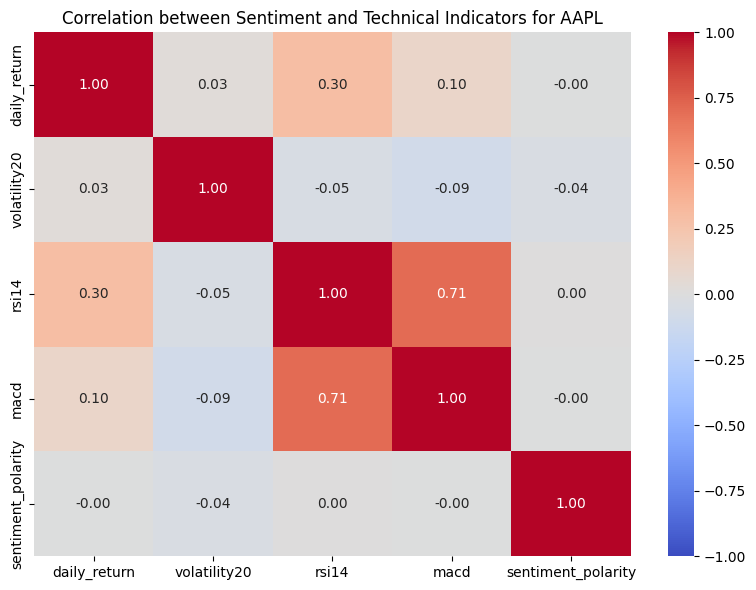

In [40]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Correlation between Sentiment and Technical Indicators for {sample_ticker}")
save_and_show_plot(f"{sample_ticker}_sentiment_correlation_heatmap.png")

Saved plot: AAPL_sentiment_vs_return.png


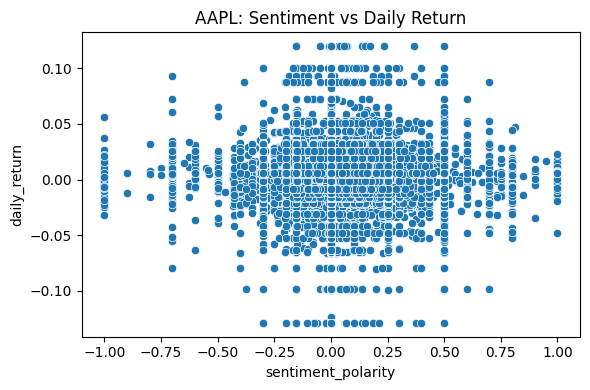

In [42]:
# scatter plot example
plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged, x='sentiment_polarity', y='daily_return')
plt.title(f"{sample_ticker}: Sentiment vs Daily Return")
save_and_show_plot(f"{sample_ticker}_sentiment_vs_return.png")